<h2>Project 1: Deep learning forecasting on retail sales with ARIMA</h2>

In this notebook we will forecast the number of orders and total income per days of a retail store that sells furnitures.

<h3> Part I - Data exploration </h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_df = pd.read_csv(r'RetailSales.csv')
input_df['Order Date'] = pd.to_datetime(input_df['Order Date'])
input_df = input_df.set_index('Order ID')
input_df = input_df.sort_values(by='Order Date')
input_df['Ship Date'] = pd.to_datetime(input_df['Ship Date'])
input_df.drop(columns = ['Row ID'], inplace=True)
print('Number of NaN values:\n' + str(input_df.isnull().sum()))
input_df.head()

Number of NaN values:
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64


,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order ID,,,,,,,,,,,,,,,,
CA-2015-140795,2015-01-02,2015-03-02,First Class,BD-11500,Bradley Drucker,Consumer,United States,Green Bay,Wisconsin,54302.0,Central,TEC-AC-10001432,Technology,Accessories,Enermax Aurora Lite Keyboard,468.900
US-2015-143707,2015-01-03,2015-05-03,Standard Class,HR-14770,Hallie Redmond,Home Office,United States,New York City,New York,10035.0,East,TEC-PH-10003655,Technology,Phones,Sannysis Cute Owl Design Soft Skin Case Cover ...,5.940
CA-2015-104269,2015-01-03,2015-06-03,Second Class,DB-13060,Dave Brooks,Consumer,United States,Seattle,Washington,98115.0,West,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,457.568
CA-2015-113880,2015-01-03,2015-05-03,Standard Class,VF-21715,Vicky Freymann,Home Office,United States,Elmhurst,Illinois,60126.0,Central,OFF-PA-10003036,Office Supplies,Paper,"Black Print Carbonless 8 1/2"" x 8 1/4"" Rapid M...",17.472
CA-2015-131009,2015-01-03,2015-05-03,Standard Class,SC-20380,Shahid Collister,Consumer,United States,El Paso,Texas,79907.0,Central,FUR-FU-10001095,Furniture,Furnishings,DAX Black Cherry Wood-Tone Poster Frame,63.552


There is no NaN except for Postal code but we don't care about this one.

We regroup the sales values and order by date by doing a sum.

In [2]:
sales_df = input_df.groupby(pd.Grouper(key='Order Date', freq='D'))['Sales'].sum()
sales_df.head(10)

Order Date
2015-01-02     468.900
2015-01-03    2203.151
2015-01-04     119.888
2015-01-05       0.000
2015-01-06    5188.520
2015-01-07     601.024
2015-01-08     228.328
2015-01-09     469.436
2015-01-10       4.710
2015-01-11    4637.816
Freq: D, Name: Sales, dtype: float64

In [3]:
order_df = input_df['Order Date'].value_counts(sort=False)
order_df = order_df.asfreq('D')
order_df = order_df.fillna(0)
order_df.tail(10)

2018-12-21    11.0
2018-12-22    27.0
2018-12-23    15.0
2018-12-24    16.0
2018-12-25    23.0
2018-12-26     4.0
2018-12-27     2.0
2018-12-28    19.0
2018-12-29    12.0
2018-12-30     7.0
Freq: D, Name: Order Date, dtype: float64

Then we plot the two time series with a moving average over 7 days in order to lower the noise.

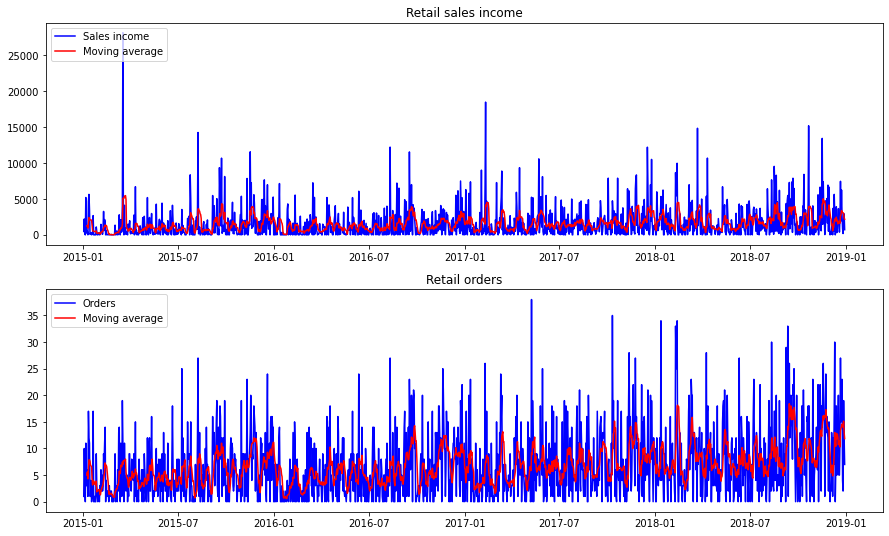

In [4]:
window_size = 7
sales_dfMA = sales_df.rolling(window=window_size, center=False).mean()
order_dfMA = order_df.rolling(window=window_size, center=False).mean()

figure, axis = plt.subplots(2, figsize=(15,9))

axis[0].plot(sales_df, color='b', label='Sales income')
axis[0].plot(sales_dfMA, color='r', label='Moving average')
axis[0].set_title('Retail sales income')
axis[0].legend(loc='upper left')

axis[1].plot(order_df, color='b', label='Orders')
axis[1].plot(order_dfMA, color='r', label='Moving average')
axis[1].set_title("Retail orders")
axis[1].legend(loc='upper left')

We can notice that the number of orders does not correlate with the income of the company.

<h3> Part II - ARIMA </h3>

ARIMA stands for 'Auto Regressive Integrated Moving Average' it's a class of models that 'explains' a given time series based on it's own past values, by using linear regression.

In order to use this model we need to make the time serie stationary, meaning the serie won't depend on time anymore, by differencing it.

An ARIMA model is defined by 3 terms: p, d, q where:
* p is the order of the Auto Regressive term
* q is the order of the Moving Average term
* d is the number of differencing required to make the time serie stationary

We'll see how to find these values, first we'll look at the differencing term (d) and the moving average (q).

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(sales_df)
print('Sales income:')
print('ADF Statistic: %f' % result[0])
print('p-value:', result[1])

result = adfuller(order_df)
print('\nOrders:')
print('ADF Statistic: %f' % result[0])
print('p-value:', result[1])

Sales income:
ADF Statistic: -13.849714
p-value: 7.041758079143861e-26

Orders:
ADF Statistic: -5.901195
p-value: 2.775484544304507e-07


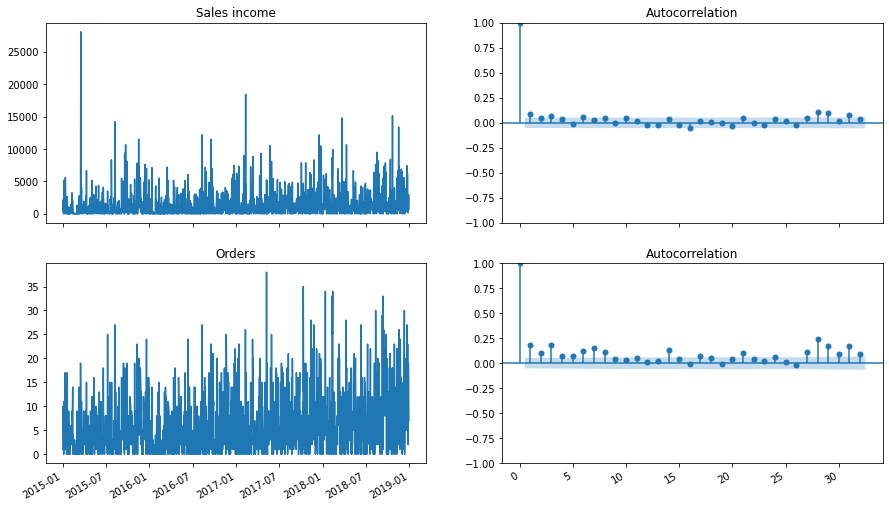

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(15,9))
fig.autofmt_xdate()

axes[0, 0].plot(sales_df); axes[0, 0].set_title('Sales income')
plot_acf(sales_df, ax=axes[0, 1])

axes[1, 0].plot(order_df); axes[1, 0].set_title('Orders')
plot_acf(order_df, ax=axes[1, 1])

plt.show()

In our case for both series P < 0.05 so there is no need for differencing. Differencing is important when P > 0.05.

Furthermore the autocorrelation plot shows a stationarity of the series, the lag 1 is way above the significance line, so we'll also fix q = 1.

Thus d = 0 and q = 1.

then we'll look at the Auto Regressive term (p):

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

C:\Users\Seren\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Seren\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


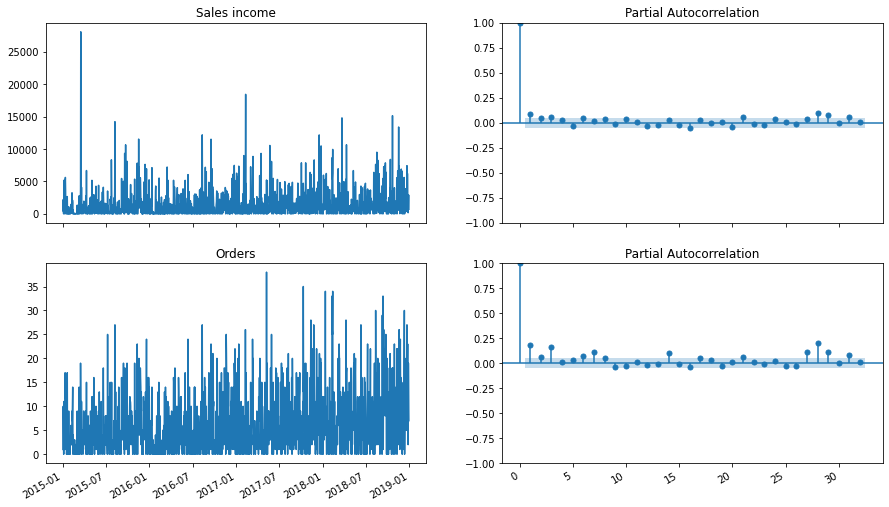

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15,9))
fig.autofmt_xdate()

axes[0, 0].plot(sales_df); axes[0, 0].set_title('Sales income')
plot_pacf(sales_df, ax=axes[0, 1])

axes[1, 0].plot(order_df); axes[1, 0].set_title('Orders')
plot_pacf(order_df, ax=axes[1, 1])

plt.show()

The lag 1 is quite significant since it's well above the significance line. We'll fix p = 1.

We can now build the ARIMA model having those informations in mind !

In [8]:
import pmdarima as pm

model = pm.auto_arima(sales_df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=26598.838, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27197.271, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=26956.506, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=27040.647, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.82 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=26982.968, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=26864.973, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.72 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=26606.050, Time=0.12 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2.927 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1459
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -1

The model managed to find the same parameters as we found for p d q with (1, 0, 1)

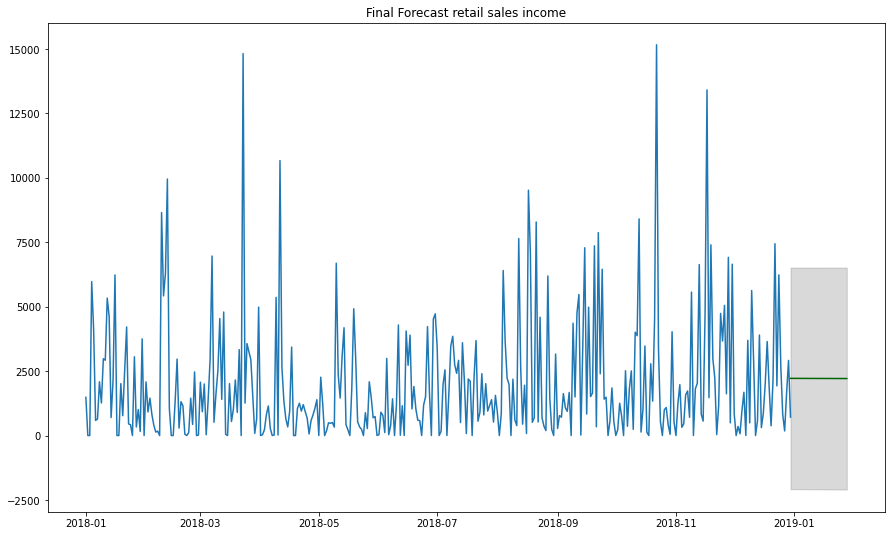

In [9]:
def predict_dates(dataset, num_prediction):
    prediction_dates = pd.date_range(dataset.index[-1], periods=num_prediction, freq='1D').tolist()
    return prediction_dates

n_periods = 30
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = predict_dates(sales_df, n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15, 9))
plt.plot(sales_df.loc['2018'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast retail sales income")
plt.show()

Yes... The result is a straight line because our time serie has no "trend" or "seasonality", the only thing ARIMA can predict in those cases is the mean of the time serie.

It will be the same result, a straight line, for the orders prediction.

In [10]:
model = pm.auto_arima(order_df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9446.245, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10631.696, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9941.602, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10216.395, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=9430.519, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=9791.640, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=9432.451, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9428.447, Time=0.75 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9430.495, Time=0.37 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=9429.625, Time=1.17 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=9432.396, Time=0.59 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=9431.708, Time=0.74 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=9431.291, Time=1.52 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]

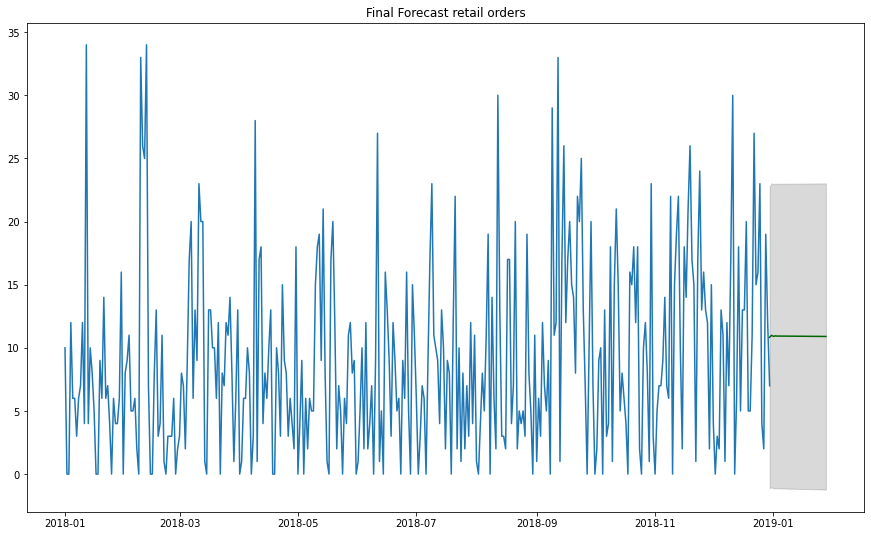

In [11]:
n_periods = 30
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = predict_dates(order_df, n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15, 9))
plt.plot(order_df.loc['2018'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast retail orders")
plt.show()

To conclude ARIMA is useful only in certain cases where the time serie has a "trend" or a "seasonality", in this case it will only predict the mean of the time serie which result in a straight line.

Furthermore we use ARIMA for short-term forecasts, long term forecasts will only result in a straight line too.